In [45]:
# What we aim to do here is numerically simulate a package of gfp molecule signal linked to a stochastically-
# varying promoter state in a gene. The idea is that if we tweak our parameters in our numerical model, we 
# can then fit the numerical model to our actual fly embryo data, in order to be able to say something about
# how this gene is turned on.

In [46]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
import gfp_signal
from telegraph import exponential

In [218]:
# Simulate a transcription promoter using my exponentially-distributed wait time telegraph signal and
# my simulation of GFP agglomeration following an "ON" or "OFF" prompt

# make the system more likely to linger in off stage: choose k_off to be less than k_on such that
#                       mean_off = 1.0 / k_off   >    1.0 / k_on
k_on = 0.03
k_off = 0.03  
duration = 555 # seconds
stepsize = 3   # seconds / step

tel = exponential(k_on, k_off, duration, stepsize)

promoter_sig = tel.signal

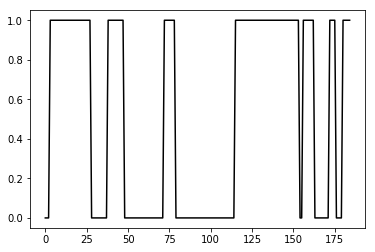

In [219]:
plt.plot(promoter_sig, color='k')

In [220]:
sum(promoter_sig) / len(promoter_sig)

0.5243243243243243

In [221]:
# Now add the numerically-simulated agglomeration of GFP stem-loops which generate the fluorescence signal we see
# parameters
sig = promoter_sig
k_gfp = 3       # gfp molecules / second
cts = 1000      # counts per gfp molecule
k_polII = 1     # how many polII's started per second
max_loops = 24  # max number of gfp loops that attach to each polII site

gfp = gfp_signal.gfp_signal(telegraph=sig, k_gfp=k_gfp, k_polII=k_polII, cts_per_gfp=cts, max_loops=max_loops, stepsize=3)

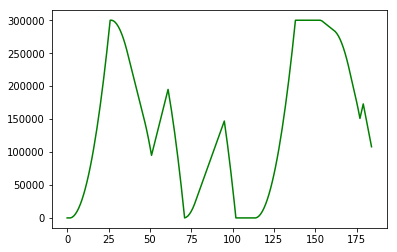

In [222]:
plt.plot(gfp.counts, color='g')

In [223]:
def autocorrelation (x) :
    """
    Compute the autocorrelation of the signal, based on the properties of the
    power spectral density of the signal.
    """
    xp = x-np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([np.real(v)**2+np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
    return np.real(pi)[:x.size/2]/np.sum(xp**2)

In [535]:
# Now let's simulate this ~80 times to create a package of traces we'd expect from actual data.
# Parameters:
k_on = 0.005
k_off = 0.01 
duration = 575   # seconds
stepsize = 3     # seconds / step

k_gfp = 1./6      # gfp chain elongation rate
cts = 1000       # counts per gfp molecule
k_polII = 1      # how many polII's started per second
max_loops = 24   # max number of gfp loops that attach to each polII site


num = 150               # number of traces in our simulated dataset
auto_traces = []       # empty list of autocorrelation arrays
traces = []            # empty list of traces 
normtraces = []     # normed traces

for i in range(num):
    tel = exponential(k_on, k_off, duration, stepsize)  # create a new signal every time      
    gfp = gfp_signal.gfp_signal(telegraph=tel.signal, k_gfp=k_gfp, k_polII=k_polII, cts_per_gfp=cts, max_loops=max_loops, stepsize=3)
    
    trace = np.asarray(gfp.norm) 
    norm_trace = np.asarray(gfp.norm)- np.mean(gfp.norm) # subtract mean fluorescence from each trace as in Desponds et al
    # (this should get rid of nucleus-to-nucleus variability)
    
    traces.append(trace)
    normtraces.append(norm_trace)
      
    auto_trace = np.correlate(norm_trace, norm_trace, 'same')
    #auto_traces.append(auto_trace / (np.std(norm_trace) * np.std(norm_trace)))   # divide each auto trace by the standard deviation squared to normalize
    
    auto_traces.append(auto_trace / np.max(auto_trace))   # divide each auto trace by its maximum to normalize to 1.

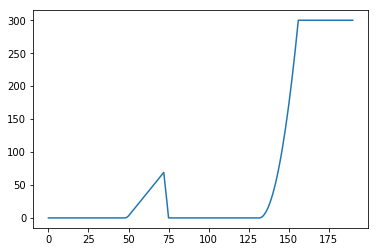

In [536]:
plt.plot(traces[8])
plt.show()

In [537]:
print("mean fluorescence of trace 8 = " + str(np.mean(traces[8])))

mean fluorescence of trace 8 = 71.72774869109948


In [538]:
def loop_fn(maxloops, gfp_elong):
    return np.arange(1, maxloops+1, gfp_elong).astype(int)  # loop function that describes GFP MS2 loop aggregation

In [539]:
# define our average fluorescence function according to Desponds et al's analytic model such that we can fit for p_on
# P_on = <Fluorescence> / sum(loop function)
def avg_flr(trace, p_on):
    maxloops = 24
    gfp_elong = 1./6
    
    loop = loop_fn(maxloops, gfp_elong)    
    trace = np.asarray(trace)
    
    return p_on * np.sum(loop)

In [540]:
# compute average fluorescence for each raw simulated trace
avg_flors = []
for i in traces:
    avg_flors.append(np.mean(i))
np.asarray(avg_flors);

In [541]:
# give us an easy range to fit over
x = np.arange(len(avg_flors))

In [542]:
# do a multiple linear regression fitting for the constant parameter, p_on.
popt_pon,_ = curve_fit(avg_flr, x, ydata=avg_flors)
print("Average fitted P_on for trace package = " + str(popt_pon))

Average fitted P_on for trace package = [0.09416269]


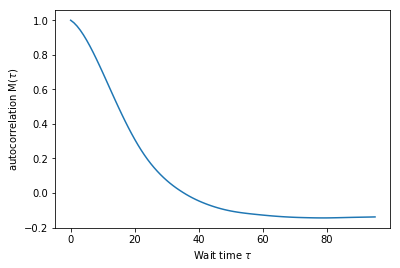

In [543]:
# Now compute the average correlation function from the set of 70.
# We see that the autocorrelation function appears as a decay curve
mean_auto_data = np.mean(auto_traces, axis = 0)
plt.plot((mean_auto_data[np.argmax(mean_auto_data):]))   # plot only half of the autocorrelation function (symmetric on both sides of max)


t = np.linspace(start=0,stop=100 )

plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'autocorrelation M($\tau$)')
plt.show()

In [544]:
# create a routine that bootstraps a set of data arrays according to Coulon & Lardon (2016)

cutoff = np.argmax(mean_auto_data)    # take only the right half of autocorrelation fns, based on our og dataset's max
normtraces = np.asarray(normtraces)           # convert to a numpy array to play with indices
n_traces = len(traces)                # number of traces in our dataset
n_trials = 1000                      # how many times we wish to compute the bootstrap loop
trace_indx = np.arange(n_traces)      # the index range of the list of traces
auto_averages = []                    # list of averaged autocorrelation functions (should be n_trials long)


# sample randomly, with replacement, a new set of n_traces 10,000 times
for i in range(n_trials):
    
    # from our list of traces, sample radomly the trace_index of these datum in the list
    random_indx = np.random.choice(trace_indx, size=n_traces, replace=True)  
    
    # then use this array of indices to create our random package of traces
    sample_set = normtraces[random_indx]
    auto_list = []
    
    # next compute the autocorrelation function from this package of traces
    for sample in sample_set:
        aut = np.correlate(sample, sample, 'same')
        #auto_list.append(aut / (np.std(sample) * np.std(sample)))   # normalize each correlation for easy fitting later
    
        auto_list.append(aut / np.max(aut))   # normalize each autocorrelation to 1

    
    auto_mu = np.mean(auto_list, axis=0)      # now average together the autocorrelation functions from the list    
    auto_averages.append(auto_mu[cutoff:])    # add the right half of the average to the list of average autocorrelation functions


In [545]:
auto_averages = np.asarray(auto_averages)

In [546]:
# now let's compute the standard deviations of the set of 10000 autocorrelation functions. This is the STANDARD ERROR
# on our dataset
# compute at each time step (tau):
std_dev_arr = np.std(auto_averages, axis=0)

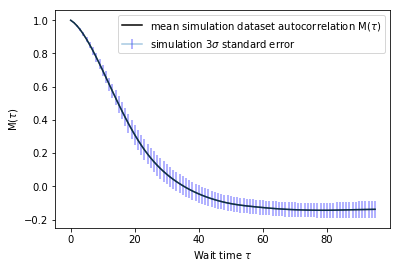

<Figure size 432x288 with 0 Axes>

In [547]:
tau = np.arange(len(mean_auto_data[cutoff:]))   # tau array to plot against

plt.errorbar(x=tau, y=mean_auto_data[cutoff:], yerr=(std_dev_arr*3, std_dev_arr*3), ecolor='b', alpha=0.4, label = r'simulation $3\sigma$ standard error')  

# show the mean of our original dataset in red
plt.plot(tau, mean_auto_data[cutoff:], color='k', label = r'mean simulation dataset autocorrelation M($\tau$)')
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'M($\tau$)')
plt.show()

plt.savefig('/Users/tmakinen/Documents/plots/errorbar.png', dpi='figure', bbox_inches='tight', overwrite=True)

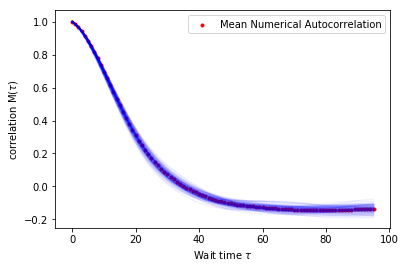

In [548]:
for i in auto_averages[::10]:
    plt.plot(i/np.max(i), color='b', alpha=0.05)   # plot a bunch of our traces to see error zones
    
plt.scatter(tau, mean_auto_data[cutoff:] /np.max(mean_auto_data[cutoff:]), marker='.', color='r', label = 'Mean Numerical Autocorrelation')   # show the mean of our original dataset in red
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'correlation M($\tau$)')
plt.show()

In [549]:
""""
Autocorrelation function analysis using Despond et al's two-state model
parameters:
    p_on: probability that system is in an on state, p_on = k_on / k_off + k_on
    k_on: given as 1/mu for exponential distribution of ON wait times
    k_off: 1/mu for exponential distribution of OFF wait times
    k_gfp: gfp loop agglomeration rate such that L(t) = k_gfp*t, L(t) !> maxloops
    maxloops: max number of gfp loops allowed in chain
    """


def autocorr(t, chartime):  # take in parameters and t (index of signal data array)
    
    #k_on = pars[0]
    #k_off = pars[1]
    
    stepsize = 3   # seconds / step

    k_gfp = 3       # gfp molecules / second
    cts = 1000      # counts per gfp molecule
    k_polII = 1     # how many polII's started per second
    max_loops = 24  # max number of gfp loops that attach to each polII site
    
    
    v_elg = 1/6     # elongation rate of GFP MS2 loop chain
    timestep = 3
    v_elg_step = v_elg * timestep  # elongation rate by timestep
    maxloops = 24   # max number of loops allowed in chain
    r=maxloops      # index

    loop = np.arange(1, maxloops+1, v_elg_step).astype(int)  # loop function that describes GFP MS2 loop aggregation
    
    # write analytic autocorrelation function according to Desponds et al:
    
    # chartime is defined as k_on + k_off
    
    delta = 1 - chartime
    
    #frac = 1 / ((1/k_on) + (1/k_off))
        
    p_on = 0.085
    p_off = (1-p_on)
    
       
    # write a for loop to do the double sums:
    sm = 0
    test = 0
    for i in np.arange(1,r+1):
        for j in np.arange(1,r+1):
            sm += p_on*p_off*(loop[i] * loop[j] * np.exp((delta-1)*np.abs(t - j + i)))
                        
       
    return sm / np.max(sm)   # normalize to 1

In [554]:
575//stepsize

191

In [ ]:
# do a correction for the fact that our time traces are of finite length
def finite_autocorr(auto_fn, r, duration):
    k = duration // stepsize    # length of our simulated time traces (steady state duration)
    
    smm = 0
    
    for i in range(k-1):
        smm += 2*(k - i)*
    
    return (auto_fn + (1/k)*((1/k) - (2/(k-r))*(k*auto_fn + sm)))
    
    


In [550]:
dat = mean_auto_data[cutoff:]
t = np.arange(len(dat))

In [551]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(autocorr, t, dat)

popt,pcov

(array([0.12716395]), array([[0.0001287]]))

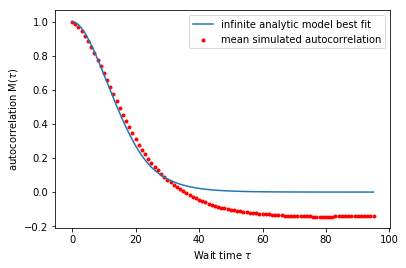

In [553]:
#plt.plot(tau, mean_auto_data[cutoff:])
plt.plot(t, autocorr(t, popt[0]), label='infinite analytic model best fit')
plt.scatter(t,dat, marker='.', color='r', label = 'mean simulated autocorrelation')   # show the mean of our original dataset in red
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'autocorrelation M($\tau$)')
plt.show()

NameError: name 'ac' is not defined

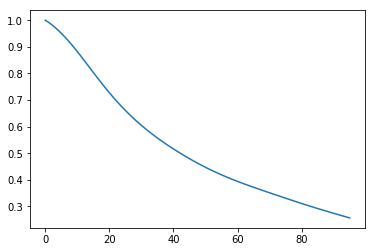

In [420]:
plt.plot(tau,mean_auto_data[cutoff:])
plt.plot(ac)

In [162]:
plt.plot(loop)


NameError: name 'loop' is not defined

In [48]:
dat = mean_auto_data[cutoff:]

In [67]:
t = np.arange(96)